# Goal: Build singles rate histogram

In order to correct for differences in detection efficiencies and solid angles, we will divide all of the doubles rates by the singles rates of the two detectors as follows:

$ W_{i,j} = \frac{D_{i,j}}{S_i*S_j}$

This requires calculating $S_i$ and $S_j$ from the `cced` files. I need to rewrite my analysis from the beginning, or write another function that parses the `cced` file.

I want to produce a histogram of event rates for each detector vs. $\Delta t$.

Note: This will have to go in the `bicorr_e` module because I am going to call functions from `bicorr` and `bicorr_e`, and `bicorr_e` is farther down the pipeline from `bicorr`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy.io as sio

In [2]:
sys.path.append('../scripts/')

In [58]:
import bicorr as bicorr
import bicorr_e as bicorr_e
import bicorr_math as bicorr_math

In [4]:
%load_ext autoreload
%autoreload 2

# Look at what I did before

In generating the `bicorr` file, I had to parse `cced` and calculate `\Delta t` for all detectors in a bicorrelation event. I want to repeat the process now, but on all events rather than on bicorrelation events only.

Is there any way I can use `pandas` to organize the data better?

I am going to work with the data that I used in the `generate_bicorr` analysis. Store the folder path for convenience. Note: This is a tiny file with only 10,000 lines of data, so the plots here will not look smooth at all. 

In [5]:
data_path = '../datar'

In [6]:
os.listdir(data_path)

['1',
 '2',
 'bhm_e.npz',
 'cced1',
 'cced1_note.md',
 'cced1_part',
 'cced1_part_note.md',
 'singles_hist.npz',
 'sparse_bhm.npz',
 'timeOffset.txt',
 'timeOffset_note.txt']

# Import time offset data, build channel lists

I am going to follow the process that I developed in `generate_bicorr`, which is available online: <https://github.com/pfschus/fission_bicorrelation/blob/master/analysis/generate_bicorr_from_cced.ipynb>

In [7]:
os.listdir('../meas_info/')

['detector_distances.xlsx',
 'detector_positions.xlsx',
 'det_df.csv',
 'det_df.pkl',
 'det_df_pairs_angles.csv',
 'det_df_pairs_angles.pkl',
 'lanl_detector_angles.mat',
 'lanl_detector_angles_note.md']

In [8]:
os.path.join(data_path,'timeOffset.txt')

'../datar\\timeOffset.txt'

In [9]:
timeOffsetData = np.genfromtxt(os.path.join(data_path,'timeOffset.txt'))

In [10]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag=True)

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


In [11]:
X, Y = np.meshgrid(chList, chList)

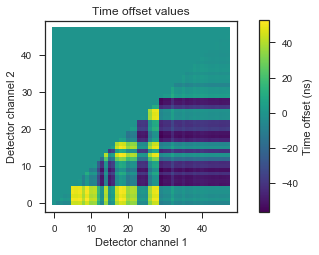

In [24]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
sc = ax.scatter(X, Y, c=timeOffsetData, s=14,edgecolor='none', marker='s', cmap = 'viridis')
cbar = plt.colorbar(sc, fraction = 0.043, pad=0.1)
cbar.set_label('Time offset (ns)')
ax.set_aspect('equal')
plt.xlabel('Detector channel 1')
plt.ylabel('Detector channel 2')
plt.title('Time offset values')
plt.show()

The syntax for calling a value from timeOffsetData is:
`timeOffsetData[d1][d2]`

where `d1` is the first detector channel number and `d2` is the second detector channel number. In all cases, `d1` must be less than `d2`. The indices where `d1` is greater than `d2` are empty in `timeDataOffset`.

# Start with the `cced` file

Go back to one I did in the process of generating the `bicorr` file. Borrowing techniques from `bicorr.generate_bicorr`. 

The columns in the `cced` file are:

* 1) event number, `event`
* 2) channel number, `detector`
* 3) particle (1=n, 2=g) `particle_type`
* 4) time, $ns$ `time`
* 5) PSD total integral `totint`
* 6) pulse height `height`

## Load `cced` file

I'm going to work with the `cced` file in the folder `../2016_11_30_pfs_generate_bicorr_from_cced/1`. 

In [25]:
ccedType = np.dtype([('event', np.int32), ('detector', np.int8), ('particle_type', np.int8), ('time', np.float16), ('integral', np.float32), ('height', np.float32)])

In [26]:
data = np.genfromtxt(os.path.join(data_path,'cced1'),dtype=ccedType)

In [27]:
data[0]

(1, 7, 2, 60.44, 1.65172, 0.20165)

## Loop through each event

* Store each cced event's contents
* Identify detector channels
* Are corresponding fc channels present?
* For those that are ^, calculate $\Delta t$

In [28]:
print_flag = False

# l is the line number of the current line, starting at 0.
# e is the event number of the current line, starting at 1

# eventNum is the current event number, extending from lines i to j.
eventNum = data[0]['event']; # Start with the first event in the data chunk.
                             # If reading entire file, this is 1. 
                             # If reading a chunk, this may be higher.
i = 0;                       # First line number of first event is always 0

# This is a clever way of keeping track what line you're on. Enumerate through the event numbers, `e`, and python also keeps track of the line number `l`.
for l, e in enumerate(data[:200]['event']):
    if print_flag: print("Reading line: ",l,"; event: ",e)
    
    if e == eventNum: # Still on the same event
        pass
    if e != eventNum: # Store info from current event, move onto next event.
        j = l         # Store line number
        n_ints = j-i  # Number interactions in current event
        if print_flag: print(n_ints)
            
        if n_ints >= 2:# At least two channels
            ccedEvent = data[i:j][:]   # Data in this event
            chs_present = ccedEvent[:]['detector']   # What channels triggered?
            chs_bool = np.in1d(chs_present,detList)  # True = detector, False = fission chamber
            dets_present = chs_present[chs_bool]
            fc_corr = (16*np.floor(dets_present/16)).astype(int) # Corr fc for each det ch
            fc_bool = np.in1d(fc_corr, chs_present) # Did fc corr trigger?
            
            if print_flag: print(i,j,ccedEvent)
            if print_flag: print('Chs:', chs_present,chs_bool,'Dets:',dets_present,fc_corr,fc_bool)
            
            if sum(fc_bool) >=1 : # At least one det-fc pair triggered
                dets_present = dets_present[fc_bool]
                fc_corr = fc_corr[fc_bool]
                if print_flag: print(e-1, dets_present, fc_corr)
            
                # Set up vectors
                det_indices = np.zeros(len(dets_present),dtype=np.int8) # det in chs_present
                fc_indices  = np.zeros(len(fc_corr),dtype=np.int8) # fc in chs_present
                time_offset = np.zeros(len(dets_present),dtype=np.float16) # time offset
                
                for d in range(0,len(dets_present),1):
                    det_indices = np.where(chs_present == dets_present[d])[0]
                    fc_indices = np.where(chs_present == fc_corr[d])[0]
                    time_offset[d] = timeOffsetData[fc_corr[d]][dets_present[d]]
                    if print_flag: print(det_indices, fc_indices, time_offset)
                
                # Store dt and particle type for each detector event
                dt       = ccedEvent[det_indices]['time']-ccedEvent[fc_indices]['time']+time_offset
                par_type = ccedEvent[det_indices]['particle_type']
                if print_flag: print(dt, par_type)
                
                # Store to histogram here! (Filled in later section)
            
        
        eventNum = e      # Move onto the next event
        i = l             # Current line is the first line for next event
        

# Set up histogram

## Time

I need to store a histogram of counts vs. $\Delta t$ for each detector channel. Set it up.

In [39]:
num_dets

45

What should my time bins be? I want to store more information than I need but not take up too much disk space. This is only a 2D array, so that should not be a problem.

In [37]:
dt_bin_edges, num_dt_bins = bicorr.build_dt_bin_edges(-300,300,0.25,True)

Built array of dt bin edges from -300 to 300 in 2400 steps of 0.25 ns.


## Energy

In [33]:
e_bin_edges, num_e_bins  = bicorr_e.build_energy_bin_edges()

In [53]:
det_df = bicorr.load_det_df()
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)
dict_det_dist = bicorr.build_dict_det_dist()

In [34]:
e_min = np.min(e_bin_edges)
e_max = np.max(e_bin_edges)
e_step = e_bin_edges[1]-e_bin_edges[0]

## Allocate memory
* Dimension 0: particle type (0=n,1=g)
* Dimension 1: detector channel (need to build a dict_det_to_index for this)  
* Dimension 2: dt bin for detector

In [39]:
singles_hist = np.zeros((2,num_dets,num_dt_bins),dtype=np.uint64)

In [40]:
singles_hist.shape

(2, 45, 2400)

In [35]:
singles_hist_e_n = np.zeros((num_dets,num_e_bins),dtype=np.uint64)

In [41]:
singles_hist_e_n.shape

(45, 600)

## Implement det # -> channel index

I have already built the channel lists, so I can use that. 

`det_df` does not apply here because that is looking at detector pairs. I am looking at singles events now.

In [47]:
det_df.head()dd

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


In [43]:
det_indices = np.arange(num_dets)

In [44]:
dict_det_to_index = dict(zip(detList,det_indices))
dict_index_to_det = dict(zip(det_indices,detList))

In [50]:
dict_det_to_index[44]

41

Actually... can I just use the channel list directly?

In [39]:
detList

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [40]:
np.argwhere(detList==1)

array([[0]], dtype=int64)

Do a quick time test to compare the two.

In [41]:
%timeit dict_det_to_index[44]

The slowest run took 34.64 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 92.8 ns per loop


In [42]:
%timeit np.argwhere(detList==44)

The slowest run took 7.13 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.8 µs per loop


The dictionary is much faster by 50x. Go with that.

# Fill histogram

Add code within the loop to store events to the histogram.

I will calculate which bin the `dt` value falls into, and increment the count in that bin by 1. I must also account for the particle type. Copy the loop from earlier and figure out the code. 

In [63]:
print_flag = False

# l is the line number of the current line, starting at 0.
# e is the event number of the current line, starting at 1

# eventNum is the current event number, extending from lines i to j.
eventNum = data[0]['event']; # Start with the first event in the data chunk.
                             # If reading entire file, this is 1. 
                             # If reading a chunk, this may be higher.
i = 0;                       # First line number of first event is always 0

# Calculate important things about dt_bin_edges
# Time indices
dt_min = np.min(dt_bin_edges); dt_max = np.max(dt_bin_edges)
dt_step = dt_bin_edges[1]-dt_bin_edges[0]
num_dt_bins = len(dt_bin_edges)-1

# This is a clever way of keeping track what line you're on. Enumerate through the event numbers, `e`, and python also keeps track of the line number `l`.
for l, e in enumerate(data['event']):
    if print_flag: print("Reading line: ",l,"; event: ",e)
    
    if e == eventNum: # Still on the same event
        pass
    if e != eventNum: # Store info from current event, move onto next event.
        j = l         # Store line number
        n_ints = j-i  # Number interactions in current event
        if print_flag: print(n_ints)
            
        if n_ints >= 2:# At least two channels
            ccedEvent = data[i:j][:]   # Data in this event
            chs_present = ccedEvent[:]['detector']   # What channels triggered?
            chs_bool = np.in1d(chs_present,detList)  # True = detector, False = fission chamber
            dets_present = chs_present[chs_bool]
            fc_corr = (16*np.floor(dets_present/16)).astype(int) # Corr fc for each det ch
            fc_bool = np.in1d(fc_corr, chs_present) # Did fc corr trigger?
            
            if print_flag: print(i,j,ccedEvent)
            if print_flag: print('Chs:', chs_present,chs_bool,'Dets:',dets_present,fc_corr,fc_bool)
            
            if sum(fc_bool) >=1 : # At least one det-fc pair triggered
                dets_present = dets_present[fc_bool]
                fc_corr = fc_corr[fc_bool]
                if print_flag: print(e-1, dets_present, fc_corr)
            
                # Set up vectors
                det_indices = np.zeros(len(dets_present),dtype=np.int8) # det in chs_present
                fc_indices  = np.zeros(len(fc_corr),dtype=np.int8) # fc in chs_present
                time_offset = np.zeros(len(dets_present),dtype=np.float16) # time offset
                
                for d in range(0,len(dets_present),1):
                    det_indices[d] = np.where(chs_present == dets_present[d])[0]
                    fc_indices[d] = np.where(chs_present == fc_corr[d])[0]
                    time_offset[d] = timeOffsetData[fc_corr[d]][dets_present[d]]
                    if print_flag: print(det_indices, fc_indices, time_offset)
                
                # Store dt and particle type for each detector event
                dt       = ccedEvent[det_indices]['time']-ccedEvent[fc_indices]['time']+time_offset
                par_type = ccedEvent[det_indices]['particle_type']
                if print_flag: pass
                
                # Store to histogram here! (Filled in later section)
                for d in np.arange(len(dets_present)): # Loop through verified singles
                    # Store to time histogram
                    if print_flag: print(d,'of:',len(dt))
                    if print_flag: print('Time:', dt[d])
                    if print_flag: print('Particle:', par_type[d])
                    t_i = int(np.floor((dt[d]-dt_min)/dt_step))
                    t_i_check = np.logical_and(t_i>=0, t_i<num_dt_bins) # Within range?
                    if print_flag: print('t_i:',t_i)                    
                    if t_i_check:
                        singles_hist[par_type[d]-1,dict_det_to_index[dets_present[d]],t_i]+= 1
                        
                    # Store to energy histogram    
                    if np.logical_and(par_type[d] == 1,dt[d] > 0):
                        dist = dict_det_dist[dets_present[d]]
                        energy = bicorr_math.convert_time_to_energy(dt[d],dist)
                        if (e_min < energy < e_max):
                            e_i = int(np.floor((energy-e_min)/e_step))
                            singles_hist_e_n[dict_det_to_index[dets_present[d]],e_i] += 1
                            
        eventNum = e      # Move onto the next event
        i = l             # Current line is the first line for next event
        

In [64]:
np.sum(singles_hist)

4501

In [65]:
singles_hist.shape

(2, 45, 2400)

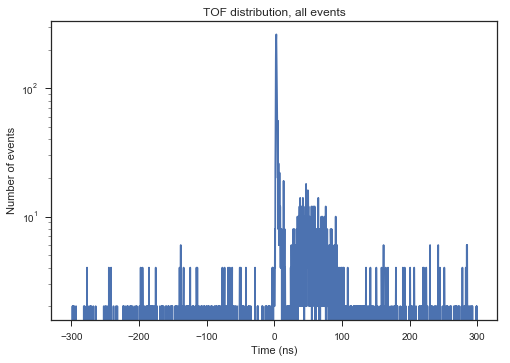

In [66]:
dt_bin_centers = (dt_bin_edges[:-1]+dt_bin_edges[1:])/2
plt.plot(dt_bin_centers,np.sum(singles_hist,axis=(0,1)))
plt.xlabel('Time (ns)')
plt.ylabel('Number of events')
plt.title('TOF distribution, all events')
plt.yscale('log')
plt.show()

In [67]:
singles_hist[0,:,:].shape

(45, 2400)

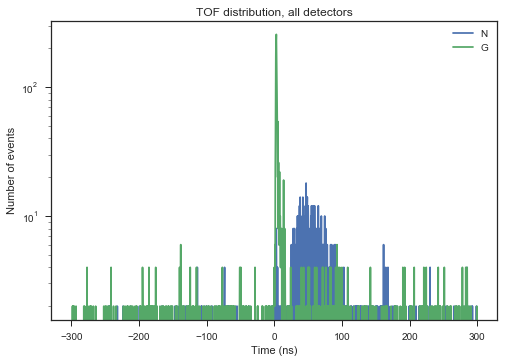

In [68]:
dt_bin_centers = (dt_bin_edges[:-1]+dt_bin_edges[1:])/2
plt.plot(dt_bin_centers,np.sum(singles_hist[0,:,:],axis=(0)))
plt.plot(dt_bin_centers,np.sum(singles_hist[1,:,:],axis=(0)))
plt.xlabel('Time (ns)')
plt.ylabel('Number of events')
plt.title('TOF distribution, all detectors')
plt.legend(['N','G'])
plt.yscale('log')
plt.show()

This looks good to me. This is only a few events, so I want to functionalize this and run it on the larger data sets on the cluster.

Now look at energy distributions.

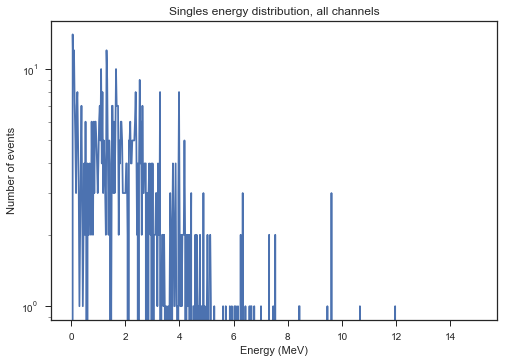

In [71]:
e_bin_centers = bicorr_math.calc_centers(e_bin_edges)
plt.plot(e_bin_centers, np.sum(singles_hist_e_n[:,:],axis=(0)))
plt.xlabel('Energy (MeV)')  
plt.ylabel('Number of events')
plt.title('Singles energy distribution, all channels')
plt.yscale('log')
plt.show()

# Store histogram to file

Save histogram and dt_bin_edges. These should be small enough to save to a .mat file, but I'll use the `npz` format to keep things consistent. How large will `singles_hist` be?

In [49]:
singles_hist.nbytes

1728000

So approximately 1.7 MB. That is perfectly acceptable.

In [50]:
np.savez(os.path.join(data_path,'singles_hist'),singles_hist=singles_hist, dict_det_to_index=dict_det_to_index, dt_bin_edges = dt_bin_edges)

In [73]:
np.savez(os.path.join(data_path,'singles_hist_e_n'),
                 singles_hist_e_n=singles_hist_e_n,dict_det_to_index=dict_det_to_index,
                 e_bin_edges=e_bin_edges)

# Functionalize this

In [74]:
help(bicorr_e.build_singles_hist_both)

Help on function build_singles_hist_both in module bicorr_e:

build_singles_hist_both(cced_filename, cced_path, dict_det_dist=None, plot_flag=True, fig_folder='fig', show_flag=False, save_flag=False)
    Parse cced file and generate histogram of singles timing information.
    
    Parameters
    ----------
    cced_filename : str
    cced_path : str
    dict_det_dist : dict, optional
    plot_flag : bool, optional
    fig_folder : str, optional
    show_flag : bool, optional
    save_flag : bool, optional
    
    Returns
    -------
    singles_hist : ndarray
        Histogram of singles timing information
        Dimension 0: particle type, 0=n, 1=g
        Dimension 1: detector channel
        Dimension 2: dt bin
    dt_bin_edges : ndarray
        Time bin array    
    singles_hist_n_e : ndarray
        Histogram of singles timing information
        Dimension 1: detector channel
        Dimension 2: e bin
    e_bin_edges : ndarray
        Time bin array
    dict_det_to_index : di

In [78]:
os.chdir('../methods/')

Loading data from:  ../datar\cced1


100%|##########| 10000/10000 [00:00<00:00, 24691.35it/s]


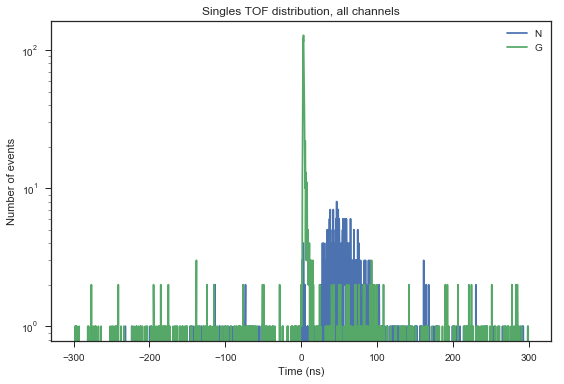

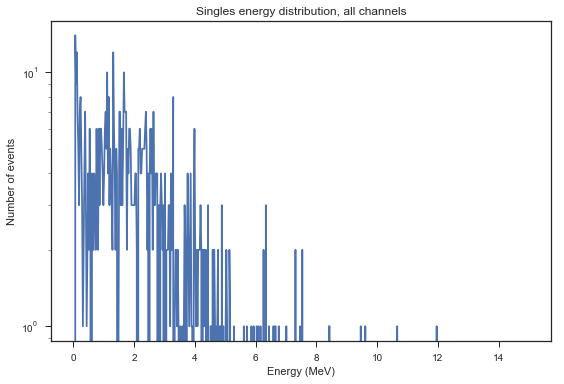

<Figure size 576x396 with 0 Axes>

In [80]:
bicorr_e.build_singles_hist_both(['cced1'],data_path,show_flag=True, save_flag = False);

Loading data from:  ../datar\cced1


100%|##########| 10000/10000 [00:00<00:00, 25510.21it/s]


Loading data from:  ../datar\cced1


100%|##########| 10000/10000 [00:00<00:00, 25252.53it/s]


Loading data from:  ../datar\cced1


100%|##########| 10000/10000 [00:00<00:00, 24937.65it/s]


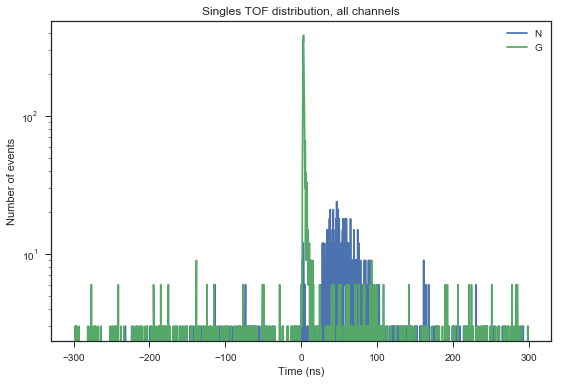

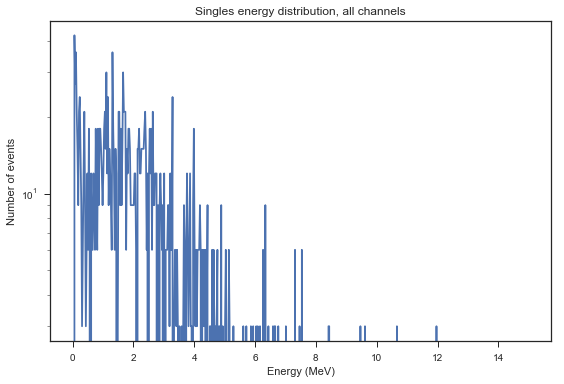

<Figure size 576x396 with 0 Axes>

In [81]:
bicorr_e.build_singles_hist_both(['cced1','cced1','cced1'],data_path,show_flag=True, save_flag = False);

Looks good


# Loop through folders

I'm going to give it a bunch of filenames. In this case, I don't want to be going in and out of folders. Hmm...

Try it here, since I have `cced1` and `cced2`.

In [84]:
os.listdir(data_path)

['1',
 '2',
 'bhm_e.npz',
 'cced1',
 'cced1_note.md',
 'cced1_part',
 'cced1_part_note.md',
 'singles_hist.npz',
 'singles_hist_e_n.npz',
 'sparse_bhm.npz',
 'timeOffset.txt',
 'timeOffset_note.txt']

In [93]:
filenames = ['1/cced1','2/cced2']

In [118]:
bicorr_e.build_singles_hist_both?

Loading data from:  ../datar\1/cced1


100%|##########| 10000/10000 [00:00<00:00, 25005.00it/s]


Loading data from:  ../datar\2/cced2


100%|##########| 10000/10000 [00:00<00:00, 25257.58it/s]


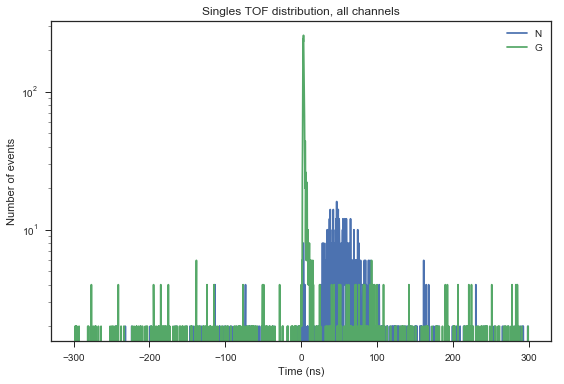

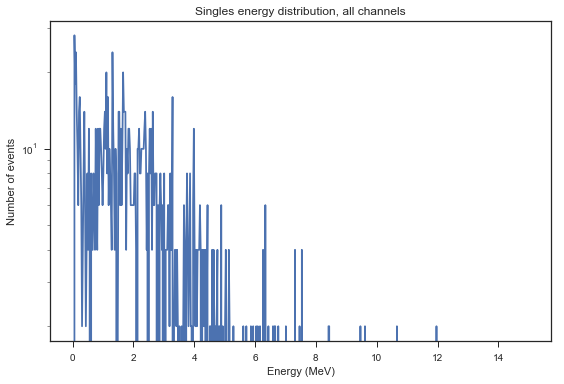

<Figure size 576x396 with 0 Axes>

In [94]:
bicorr_e.build_singles_hist_both(filenames,data_path,show_flag=True);

In [95]:
os.listdir(data_path)

['1',
 '2',
 'bhm_e.npz',
 'cced1',
 'cced1_note.md',
 'cced1_part',
 'cced1_part_note.md',
 'singles_hist.npz',
 'singles_hist_e_n.npz',
 'sparse_bhm.npz',
 'timeOffset.txt',
 'timeOffset_note.txt']

# Reload data

In [98]:
npzfile_t = np.load(os.path.join(data_path,'singles_hist.npz'))
npzfile_e = np.load(os.path.join(data_path,'singles_hist_e_n.npz'))

In [99]:
npzfile_t.files

['dict_det_to_index', 'dt_bin_edges', 'singles_hist']

In [100]:
npzfile_e.files

['dict_det_to_index', 'singles_hist_e_n', 'e_bin_edges']

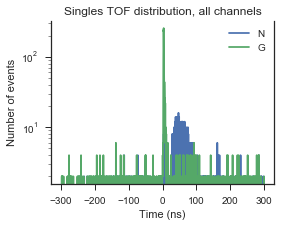

<Figure size 576x396 with 0 Axes>

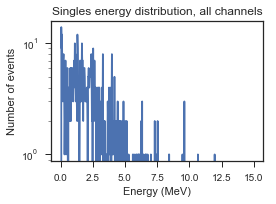

<Figure size 576x396 with 0 Axes>

In [106]:
bicorr_e.load_singles_hist_both(filepath=data_path,plot_flag=True,show_flag=True);

# Put together a script

In [116]:
num_folders = 5

In [117]:
cced_filenames = []
for folder_num in (np.arange(num_folders)+1):
    cced_filenames.append(str(folder_num) + '/cced' + str(folder_num))
print(cced_filenames)

['1/cced1', '2/cced2', '3/cced3', '4/cced4', '5/cced5']


In [119]:
for filename in cced_filenames:
    print(filename[0])

../scripts\bicorr_plot.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\ip

../scripts\bicorr_e.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipyker

1
2
3
4
5
